In [84]:
import getpass

from storyboardclient.v1 import client
api_url="https://storyboard.openstack.org/api/v1"


access_token = getpass.getpass(
    'Get a token from\n'
    'https://storyboard.openstack.org/#!/profile/tokens\n'
    'Enter token:')

storyboard = client.Client(api_url, access_token)

storyboard.stories.get(1).id

Get a token from
https://storyboard.openstack.org/#!/profile/tokens
Enter token: ····································


1

In [85]:
# Get all stories
stories = storyboard.stories.get_all()
print('Number of stories', len(stories))

# Get all tasks
tasks = storyboard.tasks.get_all()
print('Number of tasks', len(tasks))

Number of stories 27838
Number of tasks 38288


In [119]:
# Create dicts for stories and tasks
stories_dict = {}
for s in stories:
    stories_dict[s.id] = s

tasks_dict = {}
for t in tasks:
    tasks_dict[t.id] = t


In [121]:
stories_dict[1].to_dict()

{'status': 'invalid',
 'task_statuses': [{'count': 0, 'key': 'review'},
  {'count': 0, 'key': 'todo'},
  {'count': 1, 'key': 'invalid'},
  {'count': 0, 'key': 'merged'},
  {'count': 0, 'key': 'inprogress'}],
 'description': 'Trans transition',
 'title': "Dapin to ch's",
 'created_at': '2014-02-27T13:30:20+00:00',
 'tags': [],
 'updated_at': '2019-05-02T16:55:39+00:00',
 'private': False,
 'teams': [],
 'is_bug': True,
 'creator_id': None,
 'story_type_id': 1,
 'security': None,
 'id': 1,
 'users': []}

In [122]:
tasks_dict[1].to_dict()

{'status': 'invalid',
 'branch_id': 2,
 'title': "Dapin to ch's",
 'story_id': 1,
 'created_at': '2014-02-27T13:30:20+00:00',
 'updated_at': '2019-05-02T16:55:39+00:00',
 'assignee_id': None,
 'creator_id': None,
 'link': None,
 'milestone_id': None,
 'project_id': 457,
 'id': 1}

In [124]:
# Get the project group to work with
project_group_name = 'magnum'

project_group = storyboard.project_groups.find(name=project_group_name)

In [125]:
[ (project.id, project.name) for project in project_group.projects.list() ]

[(1032, 'openstack/magnum'),
 (1033, 'openstack/magnum-specs'),
 (1034, 'openstack/magnum-tempest-plugin'),
 (1035, 'openstack/magnum-ui'),
 (1036, 'openstack/python-magnumclient')]

In [126]:
project_ids = [ project.id for project in project_group.projects.list() ]
project_names = [ project.name for project in project_group.projects.list() ]
projects = {}
for project in project_group.projects.list():
    projects[project.id] = project.name

In [127]:
# Get all tasks affecting the above project group
tasks_in_group = []

for t in tasks:
    if t.project_id in project_ids:
        tasks_in_group.append(t)
print(len(tasks_in_group))

2386


In [128]:
def histogram_of_tasks(tasks):
    task_counts = {}
    for pn in project_names:
        task_counts[pn] = {}
    for t in tasks_in_group:
        project_name = projects[t.project_id]
        task_counts[project_name][t.status] = task_counts[project_name].get(t.status, 0) + 1
    return task_counts

In [140]:
histogram_of_tasks(tasks_in_group)

{'openstack/magnum': {'invalid': 659,
  'merged': 1322,
  'inprogress': 70,
  'todo': 283,
  'review': 17},
 'openstack/magnum-specs': {'todo': 3},
 'openstack/magnum-tempest-plugin': {'todo': 2, 'review': 1},
 'openstack/magnum-ui': {'todo': 1, 'merged': 9, 'invalid': 2},
 'openstack/python-magnumclient': {'invalid': 2,
  'todo': 8,
  'merged': 6,
  'review': 1}}

      0
1   659
2  1322
3    70
4   283
5    17


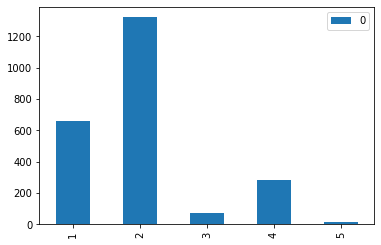

In [160]:
from pandas import pandas
d = {1: 659, 2: 1322, 3: 70, 4: 283, 5: 17}
df = pandas.DataFrame.from_dict(d, orient='index')
print(df)
df.plot.bar()

In [169]:
# Not invalid or merged Tasks in stories that are not update in the last 30d
import datetime
from dateutil.parser import parse

now = datetime.datetime.now().replace(tzinfo=None)
count = 0
for t in tasks_in_group:
    if not (t.status=='invalid' or t.status=='merged'):
        story = stories_dict[t.story_id]
        updated_at = parse(story.updated_at).replace(tzinfo=None) 
        delta = now - updated_at
        if delta.days > 360:
            count = count + 1
            print(t.id, t.story_id, '\t', 'https://storyboard.openstack.org/#!/story/%s' % t.story_id, '\t', t.title)
print(count)

20117 1543308 	 https://storyboard.openstack.org/#!/story/1543308 	 We must not disable selinux
20138 1718947 	 https://storyboard.openstack.org/#!/story/1718947 	 Limit the name of the Instance names
20159 1422831 	 https://storyboard.openstack.org/#!/story/1422831 	 Error on deleting volume on bay update
20192 1489908 	 https://storyboard.openstack.org/#!/story/1489908 	 Tech-Debt: Add tests for DB migration
20207 1539527 	 https://storyboard.openstack.org/#!/story/1539527 	 magnum service-list no response if m-cond is down
20209 1556000 	 https://storyboard.openstack.org/#!/story/1556000 	 Find an alternative way to replace WSME library
20216 1568018 	 https://storyboard.openstack.org/#!/story/1568018 	 Stable liberty seems to fail tests
20244 1704329 	 https://storyboard.openstack.org/#!/story/1704329 	 Clluster creation failed because of failure in getting etcd discovery url 
20247 1752433 	 https://storyboard.openstack.org/#!/story/1752433 	 trust invalid when user is disabled
20